# Recurrent Neural Networks In PyTorch

Learning Objectives:

* Improve understanding of the basic structure of recurrent neural networks.
* Gain experience working with simple recurrent neural networks in PyTorch. 

In this activity we will consider the problem of making real-valued predictions from one-dimensional sequence data.  For example, we might want to make a series of temperature readings every hour and then predict the temperature for the next hour from the previous 24.  The cell below contains a Python function for creating a synthetic data set of numerical sequences.

(If you are running this notebook on Google Colab, make sure to select GPU acceleration under `Edit->Notebook Settings`.)

In [1]:
%load_ext tensorboard

import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

def sin_dataset(num, length, noise =.01):
    """ Return a sequnce dataset composed of many short snippets of noisy
        sin functions.  The snippets all have randomly generated periods 
        and offsets.

        Arguments:
           num - number of sequences to return
           length - length of the sequences
           noise - std of normal noise added to each point

        Returns: x, y 
                Where x is a numpy array with shape 
                (num, lengh, 1), and y is an array with shape (length,)
                The values in y are the (noisy) next values for the 
                corresponding sequences in x
    """

    x = np.zeros((num, length, 1))
    y = np.zeros(num)
    
    delta_t = (2 * np.pi) / 30
    ins = np.arange(0, (length+1)*delta_t, delta_t)
    for i in range(num):
        data = np.sin(ins * (1.0 + np.random.random() * 4.0) + 
                      np.random.random() * 2.0 * np.pi)
        
        offset = np.random.random() * 10 - 5
        scale = .1
        data = (data + offset) * scale + np.random.randn(*data.shape) * noise
        x[i, :, 0] = data[:-1]
        y[i] = data[-1]
    return x, y


## Training Set

Execute the cell below to generate a training data set and visualize some of the input sequences.

(200000,)


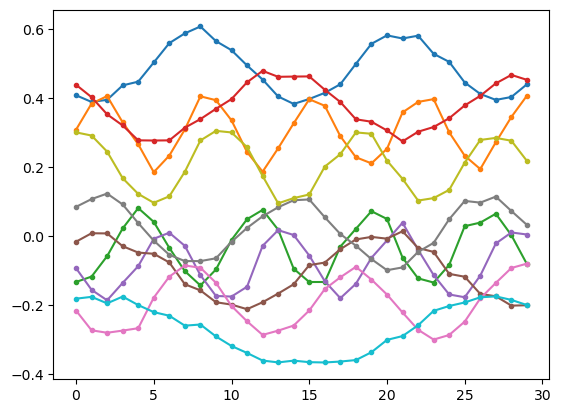

In [2]:
seq_length = 30
num_seqs = 200000
    
sequences, targets = sin_dataset(num_seqs, seq_length)
print(targets.shape)

plt.plot(sequences[0:10, : ,0].T, '.-')

plt.show()

## Data Loaders

Execute the cell below to create torch DataLoader objects to use in our training loop below.

In [3]:
import time
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter

def set_device(new_device=None):
    global device
    if new_device is None:
        if torch.cuda.is_available():
            device = "cuda"
        elif torch.backends.mps.is_available():
            device = "mps"
        else:
            device = "cpu"
    else:
        device=new_device
        
set_device()
print("Using:", device)

batch_size = 64
tensor_x = torch.Tensor(sequences)
tensor_y = torch.Tensor(np.expand_dims(targets, axis=1))

dataset = TensorDataset(tensor_x, tensor_y)

train_set, val_set = torch.utils.data.random_split(dataset, [.9, .1])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

Using: mps


## Exploring Network Structure

The cell below constructs an *extremely* simple RNN for the prediction task described above.  As you will see when you execute the cell, this network has exactly 13 weights. (This is actually a bit of a glitch in the torch RNN implementation.  The count should be 11, but torch gives each hidden unit two bias weights.)

### Questions
* On a separate sheet of paper, draw the structure of the network created in the cell below.  Every weight in the network should have a corresponding arrow in your diagram.  There should be exactly 11 arrows.
* Also on a separate sheet of paper, draw the "unrolled" version of this network for three time steps.   If drawn correctly, there should be exactly 33 arrows in your diagram (with four arrows pointing to the nonexistent hidden units from the fourth time step.)

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class SimpleRNN(nn.Module):
    
  def __init__(self):
    super().__init__()
    self.rnn = nn.RNN(input_size=1, hidden_size=2, num_layers=1, batch_first=True)
    self.out = nn.Linear(2, 1)

  def forward(self,x):
    x,_ = self.rnn(x)  # Second output is the final hidden state, which we don't need.
    x = self.out(x[:, -1, :])  # Output is the activation at the end of the sequence.
    return x

model = SimpleRNN()

print(model)
print("Num parameters: ", count_parameters(model))


SimpleRNN(
  (rnn): RNN(1, 2, batch_first=True)
  (out): Linear(in_features=2, out_features=1, bias=True)
)
Num parameters:  13


## Training

The cell below contains code for fitting a torch model.  Go ahead and train the model now...

In [ ]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()  # Set the "training" flag to true for the model.
    total_loss = 0

    start_time = time.time()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % 100 == 0:
            print(".", end="", flush=True)

    print(f"Epoch time: {time.time() - start_time:.4f}(s)")

    return total_loss / len(dataloader)


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches

    return test_loss


def train(model, train_loader, val_loader, loss_fn, optimizer, epochs):
    writer = SummaryWriter()
    for t in range(epochs):
        train_one_epoch(train_loader, model, loss_fn, optimizer)
        train_loss = test(train_loader, model, loss_fn)
        val_loss = test(val_loader, model, loss_fn)

        train_str = f"loss: {train_loss:.6f}  "
        val_str = f"validation loss: {val_loss:.6f}"

        writer.add_scalar('Loss/train', train_loss, t)
        writer.add_scalar('Loss/val', val_loss, t)

        print(f"Epoch {t+1} " + train_str + val_str)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

set_device()
model = model.to(device)

train(model, train_loader, val_loader, loss_fn, optimizer, epochs=10)


.............................Epoch time: 222.9342(s)
Epoch 1 loss: 0.001795  validation loss: 0.001795
.............................Epoch time: 219.0326(s)
Epoch 2 loss: 0.001464  validation loss: 0.001472
.............................Epoch time: 206.8723(s)
Epoch 3 loss: 0.001444  validation loss: 0.001452
.............................Epoch time: 207.3760(s)
Epoch 4 loss: 0.001420  validation loss: 0.001430
.............................Epoch time: 386.3179(s)


## TensorBoard

The cell below will start up tensorboard and allow you to examine the loss values.  If you train multiple times you can refresh the page using the circular arrow on the upper-right.

In [ ]:
%tensorboard --logdir ./runs

## Examining The Results

The cell below will allow us to visulize the predictions made by our model.  First, we predict the single next value in the sequence, then we append that value to our sequence and use the resulting sequence to predict the next value.  This way we can make predictions arbitrarily far into the future.  Unfortunately, our predictions are likely to get farther and farther off as small initial errors compound.  You can re-run the cell multiple times to see what happens with different initialial sequences.

In [ ]:
# For some reason GPU was crashing on lab machines here.  
# Let's move the model back to the cpu before testing...
set_device("cpu")
model = model.to(device)

num_predict = 50

test_input, test_y = sin_dataset(1, seq_length + num_predict)
cur_input = torch.Tensor(test_input[:, 0:seq_length, :])
predictions = []
indices = []
for i in range(num_predict):
    indices.append(i + seq_length)
    y = model.forward(cur_input)
    cur_input = torch.cat((cur_input[:, 1:, :], y.unsqueeze(1)), axis=1)
    predictions.append(y.detach().numpy().flatten())

plt.plot(test_input[0, :, 0], '.-')
plt.plot(indices, predictions, '.-')
    
plt.show()

## Improving the Model

There are many things we could try that might improve the performance of our current model:
* Add more hidden units to our RNN
* Try fancier RNN units like LSTM or GRU
* Add more RNN layers


### Activity

Experiment with improving performance on the description task above.  How low can you get the validation error?  Can you significantly improve the quality of the predictions over multiple time steps? 